# Pulse Rate model demonstration

import packages

In [1]:
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt

#local imports from our lab's package opensoundscape
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram
from opensoundscape.pulse_finder import pulse_finder, pulse_finder_species_set, summarize_top_scores

#for big visuals
plt.rcParams['figure.figsize']=[15,8] 

/Users/sml161/Library/Caches/pypoetry/virtualenvs/opensoundscape-6-tAnDaV-py3.7/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Users/sml161/Library/Caches/pypoetry/virtualenvs/opensoundscape-6-tAnDaV-py3.7/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
#for debugging imported code
%load_ext autoreload
%autoreload 2

### load an audio file with a Great Plains Toad vocalization and and create a spectrogram

In [3]:
audio_path = '../tests/great_plains_toad.wav'

#load the audio file into an Audio object
audio = Audio.from_file(audio_path)

#trim the audio to the time from 0-5 seconds
audio = audio.trim(0,5)

#create a Spectrogram object
spectrogram = Spectrogram.from_audio(audio)

/Volumes/lacie/projects1/Sam-Lapp/opensoundscape/opensoundscape/spectrogram.py:93: RuntimeWarning: divide by zero encountered in log10
  spectrogram = 10 * np.log10(spectrogram)


### show the Great Plains Toad spectrogram as an image

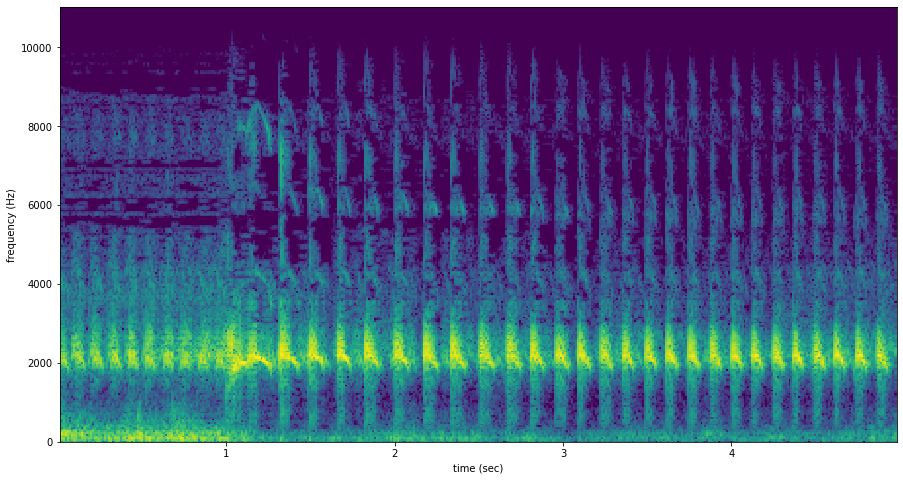

In [4]:
spectrogram.plot()

## plot the amplitude of the signal in a frequency band

In [5]:
signal_band = [1500,2500]
amplitude = spectrogram.amplitude(signal_band)

Text(0, 0.5, 'amplitude (dB)')

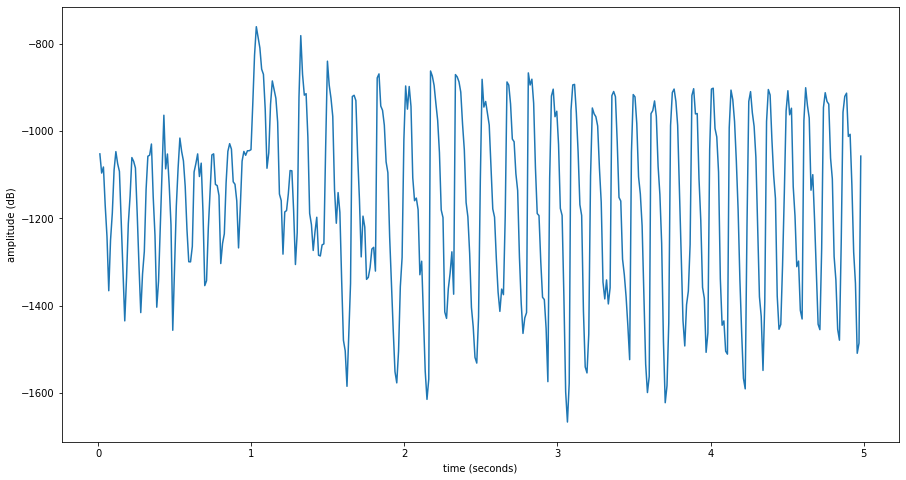

In [6]:
plt.plot(spectrogram.times,amplitude)
plt.xlabel('time (seconds)')
plt.ylabel('amplitude (dB)')

## search for pulsing vocalizations with `pulse_finder()`  

window: 0.0 sec to 1.9969160997732427 sec
peak freq: 0.5887985229492188


/Users/sml161/Library/Caches/pypoetry/virtualenvs/opensoundscape-6-tAnDaV-py3.7/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 172, using nperseg = 172
  .format(nperseg, input_length))


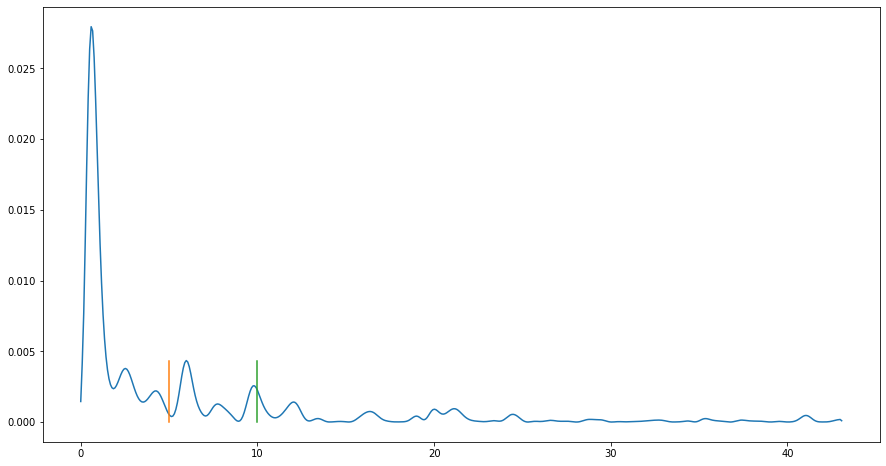

window: 1.9969160997732427 sec to 3.9938321995464854 sec
peak freq: 7.40203857421875


/Users/sml161/Library/Caches/pypoetry/virtualenvs/opensoundscape-6-tAnDaV-py3.7/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 172, using nperseg = 172
  .format(nperseg, input_length))


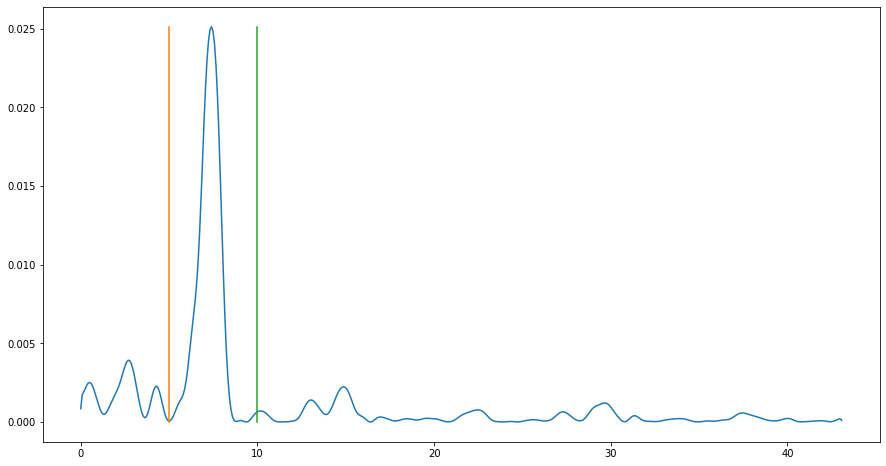

the highest score was 0.025127827341885053


In [7]:
# set some parameterse for the analysis
pulse_rate_range = [5,10] # minimum and maximum rate of pulsing, in Hz, to search for
freq_range = [1000,2000] #look for a vocalization in the range of 1000-2000 Hz 
rejection_bands = [ [0,200], [10000,10100]] # subtract the amplitude signal from these frequency ranges
window_length = 2 #(seconds) divides the signal into segments this many seconds long, analyzes each independently
show_plots = True #if True, it will show the power spectrum plot for each audio segment 

#run the analysis 
scores, times =  pulse_finder(spectrogram,
                             pulse_rate_range=pulse_rate_range,
                             freq_range=freq_range,
                             window_len=window_length,
                             rejection_bands=rejection_bands,
                             plot=show_plots)

#print out the highest score from all 2-second audio segments
print(f'the highest score was {max(scores)}')

## search for several species simultaneously with `pulse_finder_species_set()`

### create a dataframe describing the frequencies and pulse rates of each species

In [8]:
species_table = pd.DataFrame(columns=["species","pulse_rate_low","pulse_rate_high","low_f","high_f", "reject_low", "reject_high", "window_length"])
species_table.at[0,:] = ["slow_pulser",5,10,1000,2000,0,500,1.0]
species_table.at[1,:] = ["fast_pulser",20,30,1000,2000,0,500,1.0]

print('species table:')
species_table

species table:


,species,pulse_rate_low,pulse_rate_high,low_f,high_f,reject_low,reject_high,window_length
0,slow_pulser,5,10,1000,2000,0,500,1
1,fast_pulser,20,30,1000,2000,0,500,1


### search for all species using the spectrogram and dataframe

In [9]:
spectrogram = Spectrogram.from_audio(Audio.from_file(audio_path).trim(0,5))
results_table = pulse_finder_species_set(spectrogram,species_table,window_len=2.0)

#display the top scores for each species
results_table[['max_score','time_of_max_score']]

/Volumes/lacie/projects1/Sam-Lapp/opensoundscape/opensoundscape/spectrogram.py:93: RuntimeWarning: divide by zero encountered in log10
  spectrogram = 10 * np.log10(spectrogram)
/Users/sml161/Library/Caches/pypoetry/virtualenvs/opensoundscape-6-tAnDaV-py3.7/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 172, using nperseg = 172
  .format(nperseg, input_length))


,max_score,time_of_max_score
species,,
slow_pulser,0.005707,1.996916
fast_pulser,0.000181,1.996916


### perform pulse-rate analysis on a set of files and multiple species:

### get a list of files to analyze

In [10]:
files = glob('../tests/*.wav')
print(files)

['../tests/1min.wav', '../tests/great_plains_toad.wav', '../tests/veryshort.wav']


### run the pulse_finder analysis, saving the results for each file into a list

In [11]:
result_dfs = [] #store the result dataframes from each file in this list

for file in files:
    print(f'analyzing {file}')
    
    #load the audio file into an object
    audio = Audio.from_file(file, sample_rate=32000)
    
    #create a spectrogram with high time-resolution (less samples per window)
    # the time resolution will be window_samples/sample_rate = .0004 seconds
    spectrogram = Spectrogram.from_audio(audio,window_samples=128,overlap_samples=0)
    
    #run the pulse rate analysis for all species in the species dataframe
    result_df = pulse_finder_species_set(spectrogram,species_table,plot=False)
    result_dfs.append(result_df.reset_index()) #save the results into our list of result dataframes

analyzing ../tests/1min.wav
analyzing ../tests/great_plains_toad.wav


/Users/sml161/Library/Caches/pypoetry/virtualenvs/opensoundscape-6-tAnDaV-py3.7/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))


analyzing ../tests/veryshort.wav


### create a clean summary of the top scores for each species, for each file - discarding other information

In [12]:
scale_factor = 10000 #rescale values by a constant so that they are more readable
summarize_top_scores(files,result_dfs,scale_factor)

species,slow_pulser,fast_pulser
file,,
../tests/1min.wav,0.225727,0.105788
../tests/great_plains_toad.wav,0.783797,0.457865
../tests/veryshort.wav,NaN,NaN
